# Analysis Classes - a Unified Interface to Analysis Results

MVG comes with a set of analysis classes which provide a unified interface to analysis results *irrespective of the specific feature*. Note that the analysis classes are helper classes, as such the mvg class does *not* depend on them.

Except for step (1) requesting the specific feature analysis, the following generic workflow holds
(1) Request a specific analysis
(2) Retrieve results and parse them into an analysis_class object
(3) Use generic methods like plot(), summary() or to_df()

One application is to use the analysis classes interactively from a Python REPL session.

#### Or in (pseudo) code
```python
result = parse_results(session.get_analysis_results(request_id))  # call API to get results
result.plot() # plot results
result.summary() # print summary table
df = result.to_df() # convert to DataFrame
result.save_pkl() # save to pickle file
```

### Prerequisites
For running the examples in this notebook:
* Installed mvg package
* A token for API access from Viking Analytics
* The database needs to be populated with our example assets. This can be achieved by running the ["Sources and Measurement"](sources_and_measurements.ipynb) example.

## Example flow

### Importing the required packages, classes and functions

In [1]:
import os
import json
from requests import HTTPError

# import mvg library with python bindings to mvg-API
from mvg import MVG, analysis_classes
# import analysis classes
from mvg.analysis_classes import parse_results

### Create a Session and test API access

Note that the `TOKEN` is used both for authorization and authentication. Thus, each unique token represents a unique user and each user has their own unique database on the Viking Analytics MultiViz Vibration service.

**You need to insert your token received from Viking Analytics here:**

In [2]:
# Replace by your own Token
TOKEN = os.environ["TEST_TOKEN"] # use our own token
ENDPOINT = os.environ["TEST_URL"] # use API URL "https://api.beta.multiviz.com"
session = MVG(ENDPOINT, TOKEN)
print(json.dumps(session.check_version(), indent=4)) # Check if API is accessible

Using developer API: 0.0.0-dev0. You must confirm compatibility yourself.


{
    "api_version": "0.0.0-dev0",
    "mvg_highest_tested_version": "0.1.12",
    "mvg_version": "0.6.3"
}


###  Running the Analyses

Once the API session is live, we start by checking if the source u0001 we will use is available in the database:

In [3]:
SOURCE_ID = "u0001"
s_info = session.get_source(SOURCE_ID)
print(json.dumps(s_info, sort_keys=False, indent=4))

{
    "source_id": "u0001",
    "meta": {
        "assetId": "assetA",
        "measPoint": "mloc01",
        "location": "paris"
    },
    "properties": {
        "data_class": "waveform"
    }
}


### Requsting the Analysis

We will now request an analysis (first two lines, uncomment one of them) and wait for the results to become available. 

The results as returned will be stored in a dictionary named `raw_result`. The raw results are shown in the results cell, mainly to show that they are not optimized for readability or interpretation.

In [4]:
# Specifc part : Select one of two anlysis here by un/commenting
selected_feature = "RMS"
# selected_feature = "ModeId"

# Generic Part: request analysis and wait for results
analysis_request = session.request_analysis(SOURCE_ID, selected_feature)
print(f"Waiting for {analysis_request}")
session.wait_for_analyses([analysis_request["request_id"]])

# Generic Part: Displaying unparsed results
raw_result = session.get_analysis_results(analysis_request["request_id"])
print(json.dumps(raw_result, sort_keys=False, indent=4)) # Pretty but pretty long

Waiting for {'request_id': '1643d1ddbf3af3fcbb831fc71ca56df5', 'request_status': 'queued'}
{
    "status": "successful",
    "request_id": "1643d1ddbf3af3fcbb831fc71ca56df5",
    "feature": "RMS",
    "results": {
        "timestamps": [
            1570186860,
            1570273260,
            1570359660,
            1570446060,
            1570532460,
            1570618860,
            1570705260,
            1570791660,
            1570878060,
            1570964460,
            1571050860,
            1571137260,
            1571223660,
            1571310060,
            1571396460,
            1571482860,
            1571569260,
            1571655660,
            1571742060,
            1571828460,
            1571914860,
            1572001260,
            1572087660,
            1572177660,
            1572264060,
            1572350460,
            1572436860,
            1572523260,
            1572609660,
            1572696060,
            1572782460,
            157286

### Showing and Browsing the results using analysis_classes
To make the results more accessible, we'll use the analysis_classes. The parse_results function will take the raw_results of (any) analysis and represent them in a python object with a number of convenience methods for summarising, plotting and exporting. For the full list of provided methods check __[the documentation](https://vikinganalytics.github.io/mvg/content/utilities_reference/analysis_classes.html)__.

The parse function will automatically determine the kind (feature) of analysis based on the raw_results.
Once the results are parsed, we can summarize them using the summary() method *irrespective of which analysis them stem from*. To verify this you can rerun the cell above by selecting another feature for the analysis.

#### Timestamps
The Vibration API requires timestamps to be represented in EPOCH time. To display human interpertable timestamps a timezone and a time unit (specifying if the timestamps are seconds 's' or milliseconds 'ms' from EPOCH). This information can be given in the parse_results calls 2nd and 3rd argument). If they are left blank EPOCH times are kept.
When exporting the results to a DataFrame, a column called "datetime" will be appended to show the human interpretable times.

In [5]:
# Parse
pretty_result = parse_results(raw_result, "Europe/Stockholm", "s")
# pretty_result = parse_results(raw_result) # show only raw timestamps
# Show summary
pretty_result.summary()

=== RMS ===
request_id 1643d1ddbf3af3fcbb831fc71ca56df5
from 20191004-13:01.00 to 20191122-13:01.00

+-------+--------------+------------+------------+------------+---------------+
|       |   timestamps |        rms |     rms_dc |         dc |   utilization |
|-------+--------------+------------+------------+------------+---------------|
| count | 50           | 50         | 50         | 50         |            50 |
| mean  |  1.57231e+09 |  0.611691  |  0.623692  | -0.120874  |             1 |
| std   |  1.26105e+06 |  0.0565414 |  0.0563824 |  0.0141936 |             0 |
| min   |  1.57019e+09 |  0.484564  |  0.497987  | -0.140524  |             1 |
| 25%   |  1.57125e+09 |  0.627912  |  0.637381  | -0.140196  |             1 |
| 50%   |  1.57231e+09 |  0.628307  |  0.6378    | -0.112316  |             1 |
| 75%   |  1.57337e+09 |  0.64684   |  0.661892  | -0.10966   |             1 |
| max   |  1.57442e+09 |  0.647694  |  0.662754  | -0.109065  |             1 |
+-------+----------

,timestamps,rms,rms_dc,dc,utilization
count,5.000000e+01,50.000000,50.000000,50.000000,50.0
mean,1.572306e+09,0.611691,0.623692,-0.120874,1.0
std,1.261051e+06,0.056541,0.056382,0.014194,0.0
min,1.570187e+09,0.484564,0.497987,-0.140524,1.0
25%,1.571245e+09,0.627912,0.637381,-0.140196,1.0
50%,1.572307e+09,0.628307,0.637800,-0.112316,1.0
75%,1.573366e+09,0.646840,0.661892,-0.109660,1.0
max,1.574424e+09,0.647694,0.662754,-0.109065,1.0


### Plotting
For visual representation of the results there is the 'plot' method:

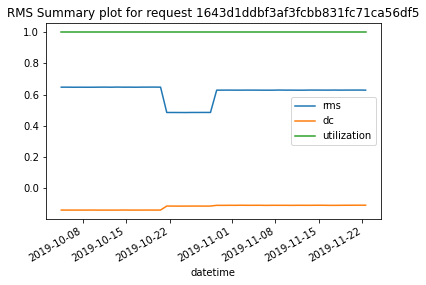

''

In [6]:
pretty_result.plot()

### Export results to DataFrame
The to_df() method will export results to a DataFrame. Note that the format of the DataFrame depends on the specific analysis and that not all of the results can be represented as a data frame.

In [7]:
pretty_result.to_df()

,timestamps,rms,rms_dc,dc,utilization,datetime
0,1570186860,0.647086,0.662108,-0.140237,1,2019-10-04 13:01:00+02:00
1,1570273260,0.647123,0.662183,-0.140420,1,2019-10-05 13:01:00+02:00
2,1570359660,0.646619,0.661652,-0.140239,1,2019-10-06 13:01:00+02:00
3,1570446060,0.646873,0.661923,-0.140347,1,2019-10-07 13:01:00+02:00
4,1570532460,0.646643,0.661714,-0.140423,1,2019-10-08 13:01:00+02:00
5,1570618860,0.646717,0.661709,-0.140055,1,2019-10-09 13:01:00+02:00
6,1570705260,0.647093,0.662171,-0.140505,1,2019-10-10 13:01:00+02:00
7,1570791660,0.647422,0.662463,-0.140363,1,2019-10-11 13:01:00+02:00
8,1570878060,0.646890,0.661977,-0.140524,1,2019-10-12 13:01:00+02:00
9,1570964460,0.647694,0.662754,-0.140486,1,2019-10-13 13:01:00+02:00


### Full results
In case the full server results are needed in the form they were returned, we can obtain them with the results() method:

In [8]:
print(json.dumps(pretty_result.results(), sort_keys=False, indent=4)) # Pretty but pretty long

{
    "timestamps": [
        1570186860,
        1570273260,
        1570359660,
        1570446060,
        1570532460,
        1570618860,
        1570705260,
        1570791660,
        1570878060,
        1570964460,
        1571050860,
        1571137260,
        1571223660,
        1571310060,
        1571396460,
        1571482860,
        1571569260,
        1571655660,
        1571742060,
        1571828460,
        1571914860,
        1572001260,
        1572087660,
        1572177660,
        1572264060,
        1572350460,
        1572436860,
        1572523260,
        1572609660,
        1572696060,
        1572782460,
        1572868860,
        1572955260,
        1573041660,
        1573128060,
        1573214460,
        1573300860,
        1573387260,
        1573473660,
        1573560060,
        1573646460,
        1573732860,
        1573819260,
        1573905660,
        1573992060,
        1574078460,
        1574164860,
        1574251260,
        1574337660

## Black Sheep Analysis example

The BlackSheep is a population analysis and has a somewhat different call signature as it requires a number of assets to be submitted to analysis.

In [9]:
# Specific signature for BlackSheep
POPULATION_SOURCES = ["u0001","u0001","u0001","u0001","u0001","u0001","u0001","u0001","u0001","u0004","u0002","u0003","u0001"]
analysis_request = session.request_population_analysis(POPULATION_SOURCES, "BlackSheep", parameters={"atypical_threshold": 0.15})

# Generic part, same as above
print(f"Waiting for {analysis_request}")
session.wait_for_analyses([analysis_request["request_id"]])
raw_result = session.get_analysis_results(analysis_request["request_id"])
print(json.dumps(raw_result, sort_keys=False, indent=4)) # Pretty but pretty long
 

Waiting for {'request_id': '35ffa9730d671736e8393a1946ba275f', 'request_status': 'queued'}
{
    "status": "successful",
    "request_id": "35ffa9730d671736e8393a1946ba275f",
    "feature": "BlackSheep",
    "results": {
        "atypical_assets": [
            {
                "uuid": "u0003",
                "timestamps": [
                    1570186860,
                    1570273260,
                    1570359660,
                    1570446060,
                    1570532460,
                    1570618860,
                    1570705260,
                    1570791660,
                    1570878060,
                    1570964460,
                    1571050860,
                    1571137260,
                    1571223660,
                    1571310060,
                    1571396460,
                    1571482860,
                    1571569260,
                    1571655660,
                    1571742060,
                    1571828460,
                    1571914860,

### Using the analysis classes
We use exactly the same code as above to inspect the results:

=== BlackSheep ===
request_id 35ffa9730d671736e8393a1946ba275f

+----+----------+------------+
|    | source   | atypical   |
|----+----------+------------|
|  0 | u0001    | False      |
|  1 | u0001    | False      |
|  2 | u0001    | False      |
|  3 | u0001    | False      |
|  4 | u0001    | False      |
|  5 | u0001    | False      |
|  6 | u0001    | False      |
|  7 | u0001    | False      |
|  8 | u0001    | False      |
|  9 | u0004    | False      |
| 10 | u0002    | True       |
| 11 | u0003    | True       |
| 12 | u0001    | False      |
+----+----------+------------+

+------------+-----+
| atypical   |   N |
|------------+-----|
| False      |  11 |
| True       |   2 |
+------------+-----+


c:\users\viking\repos\mvg\mvg\analysis_classes.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dframe["datetime"] = dt_col


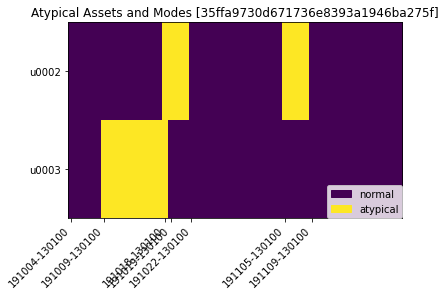

''

In [10]:
# Parse
pretty_result = parse_results(raw_result, "Europe/Stockholm", "s")
# Show summary
pretty_result.summary()
pretty_result.plot()

### Serializing
Finally, we can save the object including the results to pickle. If no name is given it is saved under the name \<request_id>.pkl.

In [11]:
pretty_result.save_pkl()

Saving BlackSheep object to 35ffa9730d671736e8393a1946ba275f.pkl


'35ffa9730d671736e8393a1946ba275f.pkl'